# Streuung der Deadlines

In [2]:
# Datenzugriff
from configs.config import get_path

# Utils
from src.utils.production_process import initialize as init
from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 26)

## Generierung des Datensatzes für 15 Tage (Ankunft)

In [4]:
day_count = 15

basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 u_b_mmax= 0.94, shift_length=1440, shuffle=True,
                                                                 job_seed=40, arrival_seed=80)
df_job_arrivals 

,Job,Production_Plan_ID,Arrival
0,0,0,49
1,1,1,130
2,2,2,151
3,3,3,226
4,4,4,386
...,...,...,...
304,304,4,21272
305,305,5,21377
306,306,6,21436
307,307,7,21541


In [5]:
df_times_all = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_times_all.rename(columns={"Deadline": "Deadline_original"}, inplace=True)
df_times_all


Schedule-Informationen:
  Makespan: 22485


,Job,Production_Plan_ID,Arrival,Deadline_original
0,0,0,49,2027.0
1,1,1,130,2683.0
2,2,2,151,2994.0
3,3,3,226,3505.0
4,4,4,386,2353.0
...,...,...,...,...
304,304,4,21272,23239.0
305,305,5,21377,23860.0
306,306,6,21436,23519.0
307,307,7,21541,24239.0


In [6]:
df_proc_time = df_jssp.groupby("Job", as_index=False)["Processing Time"].sum()
df_proc_time

,Job,Processing Time
0,0,395
1,1,510
2,2,568
3,3,655
4,4,393
...,...,...
304,304,393
305,305,496
306,306,416
307,307,539


In [7]:
df_times_all = df_times_all.merge(df_proc_time, on="Job", how="left")
df_times_all

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time
0,0,0,49,2027.0,395
1,1,1,130,2683.0,510
2,2,2,151,2994.0,568
3,3,3,226,3505.0,655
4,4,4,386,2353.0,393
...,...,...,...,...,...
304,304,4,21272,23239.0,393
305,305,5,21377,23860.0,496
306,306,6,21436,23519.0,416
307,307,7,21541,24239.0,539


In [8]:
# b) Bestimmung der "Ready Time"
df_times_all['Ready Time'] = ((df_times_all['Arrival'] // 1440) + 1) * 1440
df_times_all


,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time
0,0,0,49,2027.0,395,1440
1,1,1,130,2683.0,510,1440
2,2,2,151,2994.0,568,1440
3,3,3,226,3505.0,655,1440
4,4,4,386,2353.0,393,1440
...,...,...,...,...,...,...
304,304,4,21272,23239.0,393,21600
305,305,5,21377,23860.0,496,21600
306,306,6,21436,23519.0,416,21600
307,307,7,21541,24239.0,539,21600


## A) Normalverteilung

In [9]:
df_times = df_times_all.copy()
df_times

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time
0,0,0,49,2027.0,395,1440
1,1,1,130,2683.0,510,1440
2,2,2,151,2994.0,568,1440
3,3,3,226,3505.0,655,1440
4,4,4,386,2353.0,393,1440
...,...,...,...,...,...,...
304,304,4,21272,23239.0,393,21600
305,305,5,21377,23860.0,496,21600
306,306,6,21436,23519.0,416,21600
307,307,7,21541,24239.0,539,21600


In [10]:
# Slack berechnen (ohne Prossing Time) - eigentlich "Zeitfenster" / "verfügbare Zeit"
df_times["Slack"] = df_times["Deadline_original"] - df_times["Arrival"]


# Standardabweichung (und Mittelwert)der Slack-Zeiten
std_slack = df_times["Slack"].std()
mean_slack = df_times["Slack"].mean()

print(f"Mean Slack: {mean_slack:.2f}")
print(f"Standard Deviation of Slack: {std_slack:.2f}")

Mean Slack: 2557.13
Standard Deviation of Slack: 418.93


In [11]:
np.random.seed(50)

# Berechne eine gestreute Deadline für jede Zeile:
# - Ziehe einen Wert aus einer Normalverteilung mit Mittelwert = Deadline und Streuung = std_slack
# - Stelle sicher, dass die gestreute Deadline mindestens "Arrival + Processing Time" ist
# - Weist das Ergebnis der Spalte "Gestreute_Deadline" zu

df_times["Deadline"] = df_times.apply(
    lambda row: max(
        np.random.normal(
            loc=row["Deadline_original"],         # Mittelwert = ursprüngliche Deadline
            scale=std_slack                       # konstante Standardabweichung für alle Jobs
        ),
        row["Arrival"] + row["Processing Time"]   # Minimum: frühestmögliche sinnvolle Deadline
    ),
    axis=1  # sorgt dafür, dass apply zeilenweise arbeitet
)

# Aufrunden auf nächsten ganzzahligen Wert
df_times["Deadline"] = np.ceil(df_times["Deadline"])

In [12]:
df_times["Abweichung"] = df_times["Deadline"] - df_times["Deadline_original"]
df_times.sort_values(by="Abweichung", ascending=True).head(15)

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time,Slack,Deadline,Abweichung
83,83,7,6371,9069.0,539,7200,2698.0,7473.0,-1596.0
178,178,5,11893,14376.0,496,12960,2483.0,13203.0,-1173.0
89,89,8,6974,9963.0,597,7200,2989.0,8886.0,-1077.0
109,109,7,7912,10610.0,539,8640,2698.0,9586.0,-1024.0
81,81,0,6286,8264.0,395,7200,1978.0,7270.0,-994.0
240,240,2,16194,19037.0,568,17280,2843.0,18191.0,-846.0
288,288,8,20257,23246.0,597,21600,2989.0,22429.0,-817.0
293,293,5,20651,23134.0,496,21600,2483.0,22319.0,-815.0
162,162,6,11158,13241.0,416,11520,2083.0,12455.0,-786.0
264,264,2,18577,21420.0,568,18720,2843.0,20664.0,-756.0


In [13]:
df_times.sort_values(by="Abweichung", ascending=False).head(15)

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time,Slack,Deadline,Abweichung
16,16,1,1254,3807.0,510,1440,2553.0,5196.0,1389.0
188,188,3,12483,15762.0,655,12960,3279.0,16899.0,1137.0
52,52,5,3842,6325.0,496,4320,2483.0,7459.0,1134.0
176,176,1,11809,14362.0,510,12960,2553.0,15443.0,1081.0
135,135,5,9328,11811.0,496,10080,2483.0,12844.0,1033.0
276,276,3,19418,22697.0,655,20160,3279.0,23672.0,975.0
267,267,6,18674,20757.0,416,18720,2083.0,21680.0,923.0
76,76,4,5893,7860.0,393,7200,1967.0,8726.0,866.0
265,265,3,18585,21864.0,655,18720,3279.0,22639.0,775.0
120,120,1,8538,11091.0,510,8640,2553.0,11849.0,758.0


In [14]:
real_deviation = df_times["Abweichung"]

max_abw = real_deviation.max()
min_abw = real_deviation.min()

print(f"Ø Abweichung: {real_deviation.mean():.2f}")
print(f"Größte positive Abweichung: {max_abw:.2f}")
print(f"Größte negative Abweichung: {min_abw:.2f}")

Ø Abweichung: -15.17
Größte positive Abweichung: 1389.00
Größte negative Abweichung: -1596.00


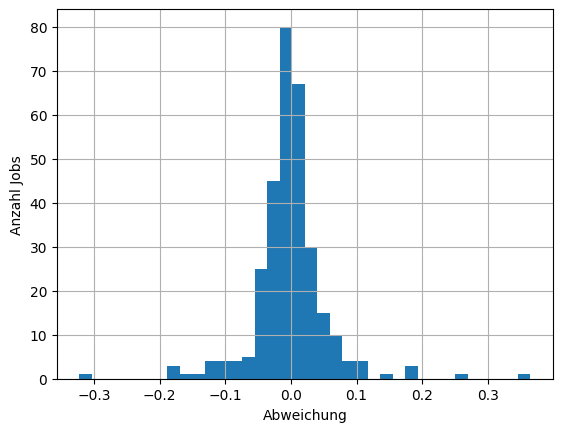

In [15]:
relative_abweichung =  (df_times["Deadline"] - df_times["Deadline_original"]) / df_times["Deadline_original"]
plt.hist(relative_abweichung , bins="auto")
plt.xlabel("Abweichung")
plt.ylabel("Anzahl Jobs")
plt.grid(True)
plt.show()

#### Export

In [16]:
# df_jssp.to_csv('data/09_jssp_for_17_days.csv', index=False)

In [17]:
# df_times = df_times[['Job', 'Arrival', 'Deadline']]
# df_times.to_csv('data/09_times_scattered_deadlines_for_17_days.csv', index=False)

## B) Dreiecksverteilung

In [18]:
df_times = df_times_all.copy()
df_times

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time
0,0,0,49,2027.0,395,1440
1,1,1,130,2683.0,510,1440
2,2,2,151,2994.0,568,1440
3,3,3,226,3505.0,655,1440
4,4,4,386,2353.0,393,1440
...,...,...,...,...,...,...
304,304,4,21272,23239.0,393,21600
305,305,5,21377,23860.0,496,21600
306,306,6,21436,23519.0,416,21600
307,307,7,21541,24239.0,539,21600


In [19]:
np.random.seed(45)

df_times["Deadline"] = df_times.apply(
    lambda row: np.random.triangular(
        left=row["Arrival"] + row["Processing Time"],   # frühestmögliches Ende
        mode=row["Deadline_original"],                  # Peak der Verteilung
        right=2 * row["Deadline_original"] - (row["Arrival"] + row["Processing Time"])  # symmetrisches Maximum
    ),
    axis=1
)

# Aufrunden auf nächsten ganzzahligen Wert
df_times["Deadline"] = np.ceil(df_times["Deadline"])

In [20]:
# Streuwert
df_times["Abweichung"] = df_times["Deadline"] - df_times["Deadline_original"]
min_abw = df_times["Abweichung"].min()
max_abw = df_times["Abweichung"].max()
mean_abw = df_times["Abweichung"].mean()

print(f"Minimale Abweichung: {min_abw:.2f}")
print(f"Maximale Abweichung: {max_abw:.2f}")
print(f"Mittlere Abweichung: {mean_abw:.2f}")

Minimale Abweichung: -2063.00
Maximale Abweichung: 2067.00
Mittlere Abweichung: 49.20


In [21]:
df_times.sort_values(by="Abweichung", ascending=True).head(15)

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time,Deadline,Abweichung
235,235,3,15787,19066.0,655,15840,17003.0,-2063.0
254,254,3,17597,20876.0,655,18720,18910.0,-1966.0
104,104,3,7744,11023.0,655,8640,9182.0,-1841.0
278,278,9,19601,22304.0,540,20160,20588.0,-1716.0
3,3,3,226,3505.0,655,1440,1913.0,-1592.0
293,293,5,20651,23134.0,496,21600,21561.0,-1573.0
191,191,9,12690,15393.0,540,12960,13826.0,-1567.0
112,112,5,8016,10499.0,496,8640,9003.0,-1496.0
78,78,1,6102,8655.0,510,7200,7186.0,-1469.0
283,283,3,19956,23235.0,655,20160,21768.0,-1467.0


In [22]:
df_times.sort_values(by="Abweichung", ascending=False).head(15)

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time,Deadline,Abweichung
12,12,8,950,3939.0,597,1440,6006.0,2067.0
242,242,3,16402,19681.0,655,17280,21736.0,2055.0
225,225,7,15281,17979.0,539,15840,19986.0,2007.0
95,95,2,7178,10021.0,568,7200,11959.0,1938.0
180,180,2,11949,14792.0,568,12960,16681.0,1889.0
71,71,9,5523,8226.0,540,5760,10096.0,1870.0
56,56,2,4216,7059.0,568,4320,8928.0,1869.0
197,197,7,13382,16080.0,539,14400,17949.0,1869.0
106,106,9,7880,10583.0,540,8640,12441.0,1858.0
265,265,3,18585,21864.0,655,18720,23690.0,1826.0


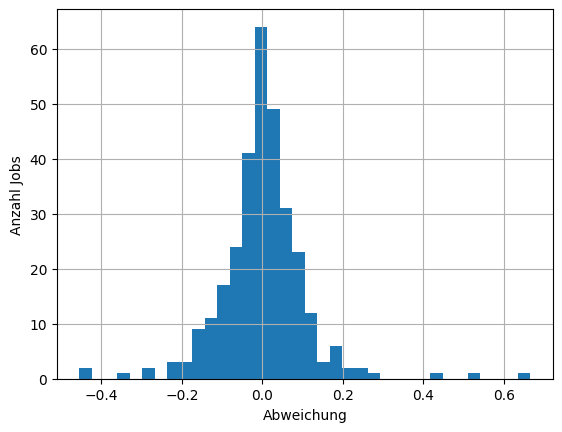

In [23]:
relative_abweichung =  (df_times["Deadline"] - df_times["Deadline_original"]) / df_times["Deadline_original"]
plt.hist(relative_abweichung , bins="auto")
plt.xlabel("Abweichung")
plt.ylabel("Anzahl Jobs")
plt.grid(True)
plt.show()

## C) Log-Normalverteilung (V1)

np.random.lognormal(mean=μ, sigma=σ)

In [24]:
df_times = df_times_all.copy()
df_times

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time
0,0,0,49,2027.0,395,1440
1,1,1,130,2683.0,510,1440
2,2,2,151,2994.0,568,1440
3,3,3,226,3505.0,655,1440
4,4,4,386,2353.0,393,1440
...,...,...,...,...,...,...
304,304,4,21272,23239.0,393,21600
305,305,5,21377,23860.0,496,21600
306,306,6,21436,23519.0,416,21600
307,307,7,21541,24239.0,539,21600


In [25]:
# Slack berechnen (ohne Prossing Time) - eigentlich "Zeitfenster" / "verfügbare Zeit"
df_times["Slack"] = df_times["Deadline_original"] - df_times["Arrival"]


# Standardabweichung (und Mittelwert)der Slack-Zeiten
std_slack = df_times["Slack"].std()
mean_slack = df_times["Slack"].mean()

print(f"Mean Slack: {mean_slack:.2f}")
print(f"Standard Deviation of Slack: {std_slack:.2f}")

Mean Slack: 2557.13
Standard Deviation of Slack: 418.93


In [26]:
variance = std_slack ** 2
mu = np.log((mean_slack ** 2) / np.sqrt(variance + mean_slack ** 2))
sigma = np.sqrt(np.log(1 + (variance / (mean_slack ** 2))))


In [27]:
np.random.seed(45)

df_times["Deadline"] = df_times.apply(
    lambda row: row["Arrival"] + row["Processing Time"] + np.random.lognormal(mean=mu, sigma=sigma),
    axis=1
)

df_times["Deadline"] = np.ceil(df_times["Deadline"])


In [28]:
sigma = 0.5
np.random.seed(45)

df_times["Deadline_List"] = df_times.apply(
    lambda row: list(
        row["Arrival"] + row["Processing Time"] +
        np.random.lognormal(
            mean=np.log(row["Deadline_original"]) - 0.5 * sigma**2,
            sigma=sigma,
            size=500
        )
    ),
    axis=1
)


In [29]:
df_times = df_times.sort_values(by="Deadline")
df_times.head(20)

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time,Slack,Deadline,Deadline_List
5,5,5,464,2947.0,496,1440,2483.0,2614.0,"[2514.2255443571576, 2206.1110608502518, 2790...."
4,4,4,386,2353.0,393,1440,1967.0,2831.0,"[1676.8076807435068, 2540.996705503033, 2784.5..."
0,0,0,49,2027.0,395,1440,1978.0,2979.0,"[2256.567328643654, 2481.488084833266, 1912.12..."
2,2,2,151,2994.0,568,1440,2843.0,3086.0,"[4071.685238479839, 3576.212803171182, 4572.48..."
7,7,7,506,3204.0,539,1440,2698.0,3235.0,"[5484.2497274318, 5731.3693361134365, 6396.959..."
1,1,1,130,2683.0,510,1440,2553.0,3273.0,"[2435.4560316405295, 1260.7525873759175, 4729...."
3,3,3,226,3505.0,655,1440,3279.0,3322.0,"[5648.787908629351, 4201.508304135976, 4514.19..."
14,14,4,1127,3094.0,393,1440,1967.0,3418.0,"[3078.1484460018546, 4545.79069264508, 3706.66..."
12,12,8,950,3939.0,597,1440,2989.0,3533.0,"[4301.225470016609, 4601.660592399587, 7248.71..."
6,6,6,480,2563.0,416,1440,2083.0,3542.0,"[4435.79296975568, 2651.7167453064358, 2598.99..."


In [30]:
df_times.tail(20)

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time,Slack,Deadline,Deadline_List
290,290,6,20482,22565.0,416,21600,2083.0,23531.0,"[43627.82190669184, 46852.72341537439, 53421.7..."
292,292,3,20493,23772.0,655,21600,3279.0,23593.0,"[33614.82895966778, 27379.57421070936, 48937.4..."
295,295,4,20779,22746.0,393,21600,1967.0,23733.0,"[37278.33350452542, 60390.918487045994, 39462...."
299,299,0,20857,22835.0,395,21600,1978.0,23758.0,"[47353.910327331454, 38428.29135636229, 34297...."
296,296,9,20783,23486.0,540,21600,2703.0,23802.0,"[49080.143821433434, 34119.0021593067, 55053.5..."
289,289,7,20381,23079.0,539,21600,2698.0,23861.0,"[35862.44523475454, 56560.71689034862, 48458.7..."
302,302,2,21174,24017.0,568,21600,2843.0,23949.0,"[36366.706403422126, 39510.474072521596, 45818..."
291,291,8,20488,23477.0,597,21600,2989.0,23969.0,"[44479.04721964769, 46354.68688556226, 51735.4..."
293,293,5,20651,23134.0,496,21600,2483.0,23976.0,"[38538.23018915593, 44178.8172132062, 29807.96..."
298,298,1,20831,23384.0,510,21600,2553.0,24009.0,"[38300.93253992585, 66825.66134313, 31633.1145..."


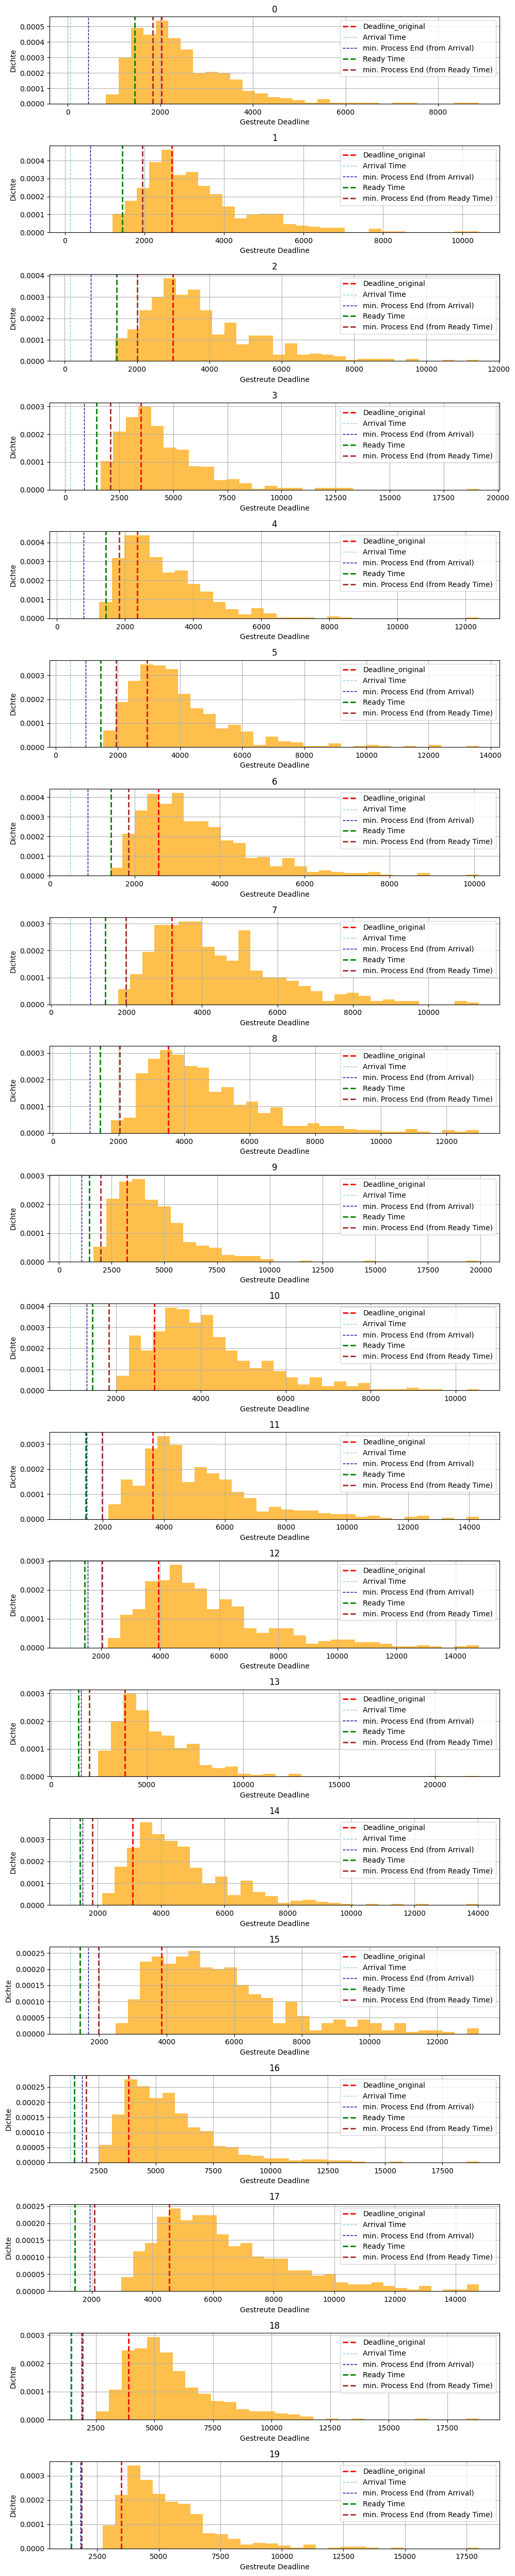

In [31]:
df_plot = df_times.sort_values(by="Job").head(20)
#df_plot = df_times.sort_values(by="Job").tail(5)

# Plots untereinander, mit vertikalem Strich für Deadline_original
fig, axes = plt.subplots(len(df_plot), 1, figsize=(10, len(df_plot) * 2.5))

for idx, (i, row) in enumerate(df_plot.iterrows()):
    ax = axes[idx]
    ax.hist(row["Deadline_List"], bins=30, density=True, alpha=0.7, color='orange')
    ax.axvline(row["Deadline_original"], color='red', linestyle='--', linewidth=2, label='Deadline_original')

    ax.axvline(row["Arrival"], color='#87CEEB', linestyle='--', linewidth=1, label='Arrival Time')
    ax.axvline(row["Arrival"]+ row["Processing Time"], color='#00008B', linestyle='--', linewidth=1, label='min. Process End (from Arrival)')
    ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')
    ax.axvline(row["Ready Time"]+ row["Processing Time"], color='brown', linestyle='--', linewidth=2, label='min. Process End (from Ready Time)')
    ax.set_title(f'{row["Job"]}')
    ax.set_xlabel("Gestreute Deadline")
    ax.set_ylabel("Dichte")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## D) Log-Normalverteilung (V2)

In [32]:
df_times = df_times_all.copy()
df_times

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time
0,0,0,49,2027.0,395,1440
1,1,1,130,2683.0,510,1440
2,2,2,151,2994.0,568,1440
3,3,3,226,3505.0,655,1440
4,4,4,386,2353.0,393,1440
...,...,...,...,...,...,...
304,304,4,21272,23239.0,393,21600
305,305,5,21377,23860.0,496,21600
306,306,6,21436,23519.0,416,21600
307,307,7,21541,24239.0,539,21600


In [33]:
sigma = 0.5  # frei wählbare Streuung (z. B. 0.2 bis 0.6 ist oft sinnvoll)
np.random.seed(41)

df_times["Deadline"] = df_times.apply(
    lambda row: np.ceil(
        max(
            np.random.lognormal(
                mean=np.log(row["Deadline_original"]) - 0.5 * sigma**2,
                sigma=sigma
            ),
            row["Arrival"] + row["Processing Time"]
        )
    ),
    axis=1
)


In [34]:
sigma = 0.5
np.random.seed(41)

df_times["Deadline_List"] = df_times.apply(
    lambda row: list(
        np.random.lognormal(
            mean=np.log(row["Deadline_original"]) - 0.5 * sigma**2,
            sigma=sigma,
            size=1000
        )
    ),
    axis=1
)


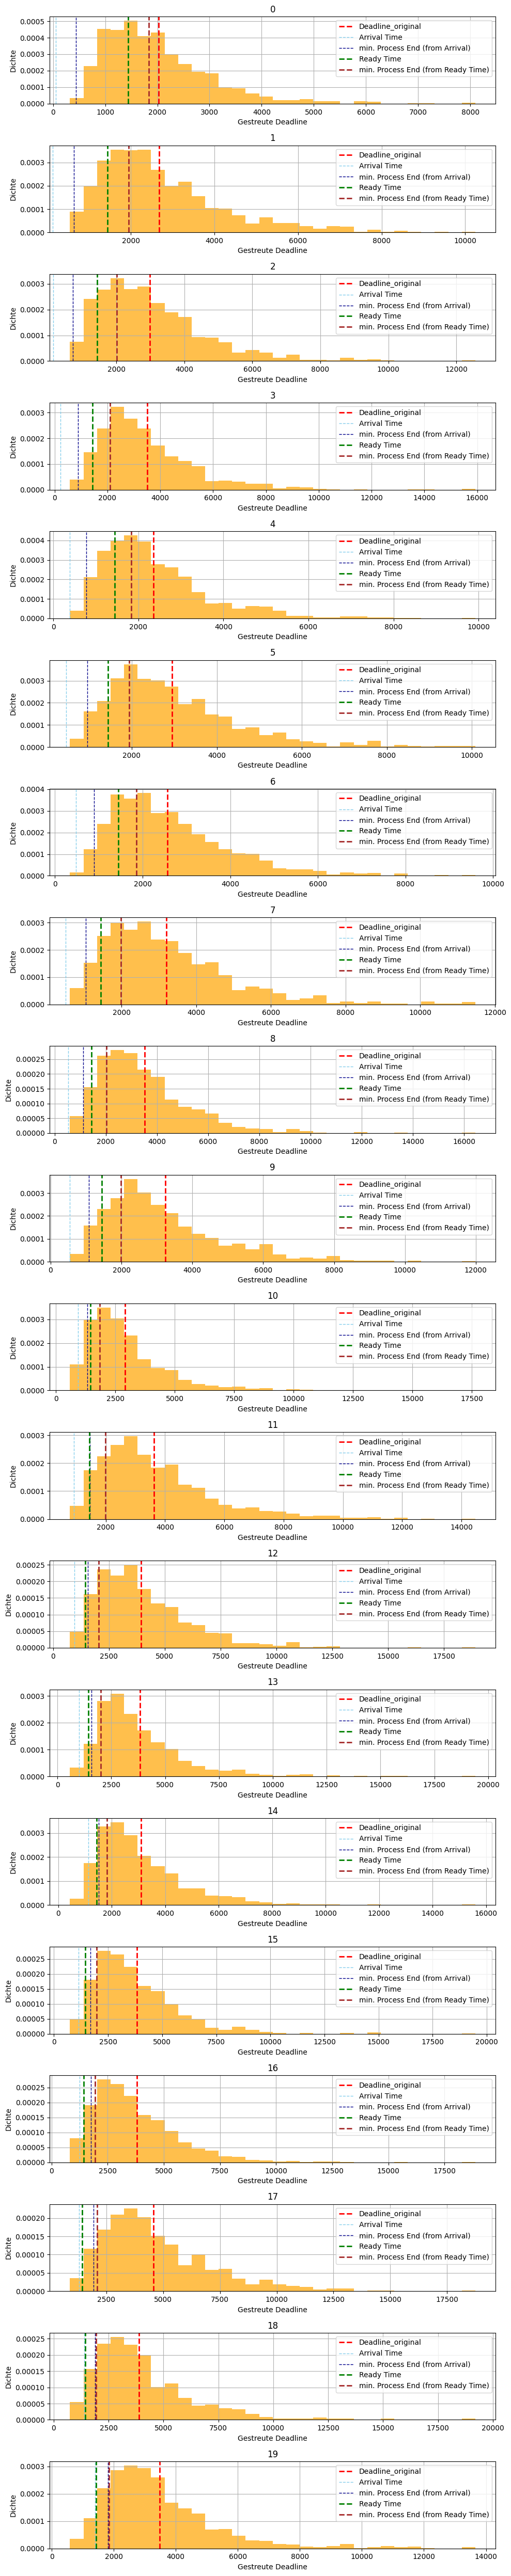

In [35]:
df_plot = df_times.sort_values(by="Job").head(20)

# Plots untereinander, mit vertikalem Strich für Deadline_original
fig, axes = plt.subplots(len(df_plot), 1, figsize=(10, len(df_plot) * 2.5))

for idx, (i, row) in enumerate(df_plot.iterrows()):
    ax = axes[idx]
    ax.hist(row["Deadline_List"], bins=30, density=True, alpha=0.7, color='orange')
    ax.axvline(row["Deadline_original"], color='red', linestyle='--', linewidth=2, label='Deadline_original')

    ax.axvline(row["Arrival"], color='#87CEEB', linestyle='--', linewidth=1, label='Arrival Time')
    ax.axvline(row["Arrival"]+ row["Processing Time"], color='#00008B', linestyle='--', linewidth=1, label='min. Process End (from Arrival)')
    ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')
    ax.axvline(row["Ready Time"]+ row["Processing Time"], color='brown', linestyle='--', linewidth=2, label='min. Process End (from Ready Time)')
    ax.set_title(f'{row["Job"]}')
    ax.set_xlabel("Gestreute Deadline")
    ax.set_ylabel("Dichte")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## E) Log-Normalverteilung (V3)
> Modus = original Deadline

In [36]:
df_times = df_times_all.copy()
df_times

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time
0,0,0,49,2027.0,395,1440
1,1,1,130,2683.0,510,1440
2,2,2,151,2994.0,568,1440
3,3,3,226,3505.0,655,1440
4,4,4,386,2353.0,393,1440
...,...,...,...,...,...,...
304,304,4,21272,23239.0,393,21600
305,305,5,21377,23860.0,496,21600
306,306,6,21436,23519.0,416,21600
307,307,7,21541,24239.0,539,21600


In [37]:
sigma = 0.5
np.random.seed(41)

df_times["Deadline_List"] = df_times.apply(
    lambda row: list(
        np.random.lognormal(
            mean=np.log(row["Deadline_original"]) + sigma**2,
            sigma=sigma,
            size=1000
        )
    ),
    axis=1
)


In [38]:
df_times

,Job,Production_Plan_ID,Arrival,Deadline_original,Processing Time,Ready Time,Deadline_List
0,0,0,49,2027.0,395,1440,"[2273.227677504576, 2742.8043812059186, 2950.0..."
1,1,1,130,2683.0,510,1440,"[2550.482341258907, 3082.249633157498, 4929.76..."
2,2,2,151,2994.0,568,1440,"[1780.3754258660601, 5905.278133268708, 1245.4..."
3,3,3,226,3505.0,655,1440,"[2360.2224206558226, 4508.638761990654, 2389.7..."
4,4,4,386,2353.0,393,1440,"[3530.1141215459106, 3749.7615077258274, 3209...."
...,...,...,...,...,...,...,...
304,304,4,21272,23239.0,393,21600,"[9260.05245507227, 8729.771812057581, 27533.77..."
305,305,5,21377,23860.0,496,21600,"[45272.642659456724, 36976.673182393206, 25476..."
306,306,6,21436,23519.0,416,21600,"[16595.96746297004, 34058.02068863247, 18859.8..."
307,307,7,21541,24239.0,539,21600,"[28161.65051949921, 23425.650169600198, 19290...."


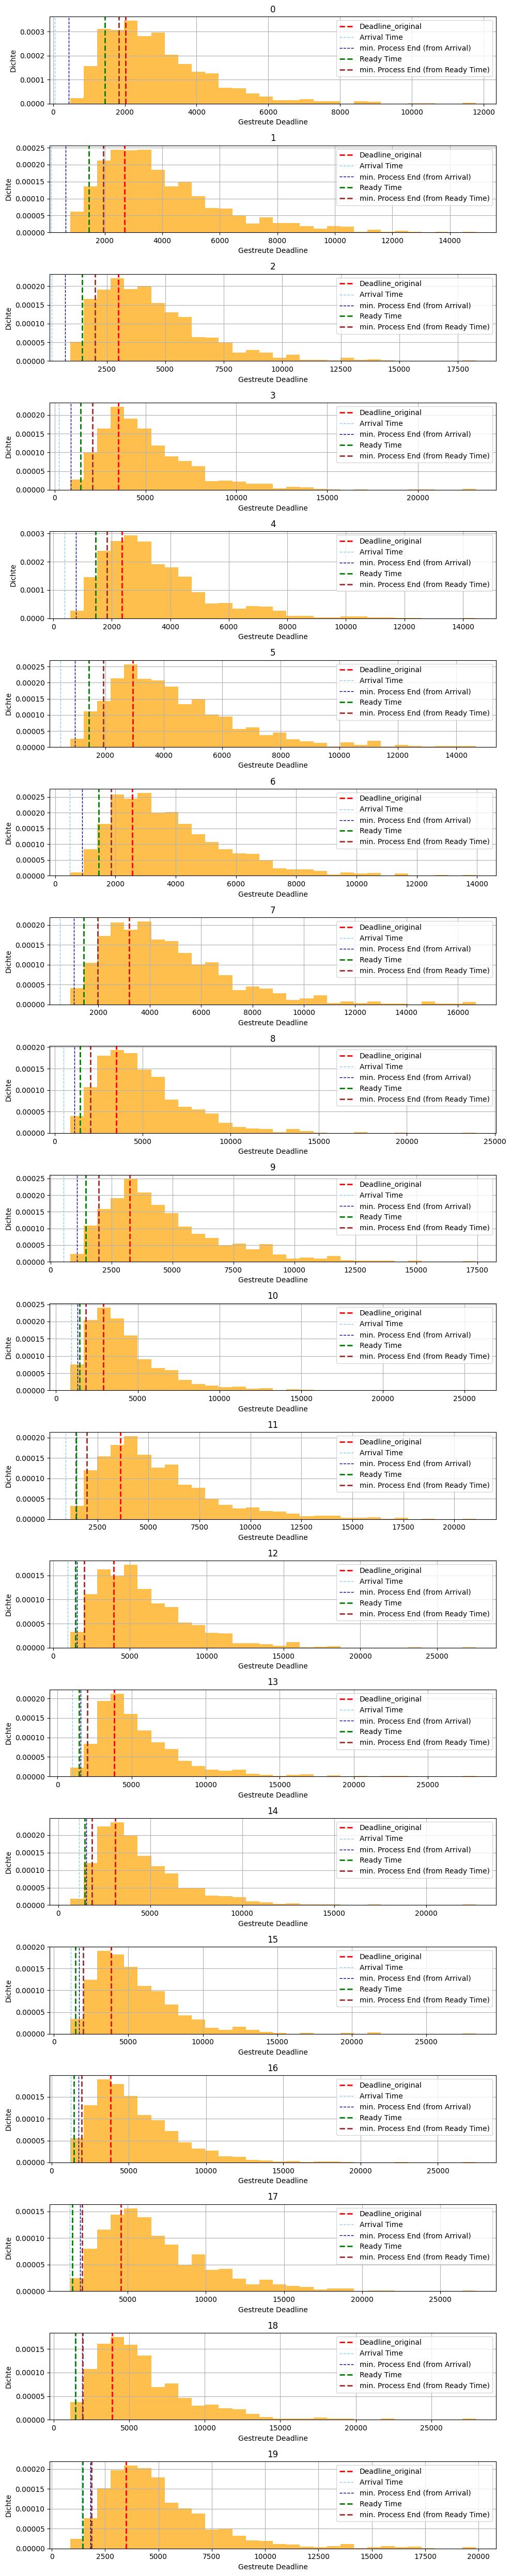

In [39]:
df_plot = df_times.sort_values(by="Job").head(20)

# Plots untereinander, mit vertikalem Strich für Deadline_original
fig, axes = plt.subplots(len(df_plot), 1, figsize=(10, len(df_plot) * 2.5))

for idx, (i, row) in enumerate(df_plot.iterrows()):
    ax = axes[idx]
    ax.hist(row["Deadline_List"], bins=30, density=True, alpha=0.7, color='orange')
    ax.axvline(row["Deadline_original"], color='red', linestyle='--', linewidth=2, label='Deadline_original')

    ax.axvline(row["Arrival"], color='#87CEEB', linestyle='--', linewidth=1, label='Arrival Time')
    ax.axvline(row["Arrival"]+ row["Processing Time"], color='#00008B', linestyle='--', linewidth=1, label='min. Process End (from Arrival)')
    ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')
    ax.axvline(row["Ready Time"]+ row["Processing Time"], color='brown', linestyle='--', linewidth=2, label='min. Process End (from Ready Time)')
    ax.set_title(f'{row["Job"]}')
    ax.set_xlabel("Gestreute Deadline")
    ax.set_ylabel("Dichte")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

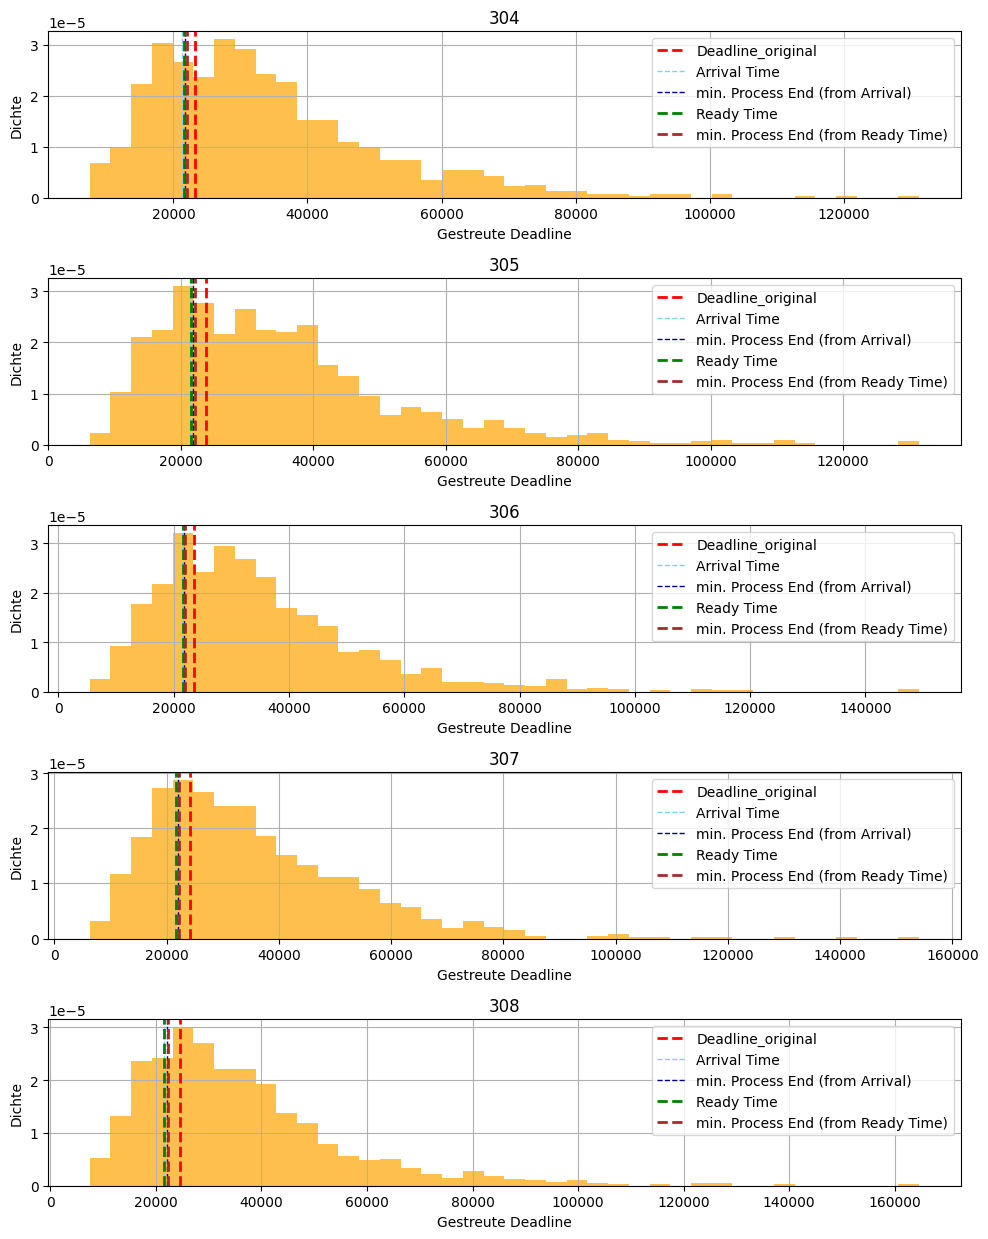

In [40]:
df_plot = df_times.sort_values(by="Job").tail()

# Plots untereinander, mit vertikalem Strich für Deadline_original
fig, axes = plt.subplots(len(df_plot), 1, figsize=(10, len(df_plot) * 2.5))

for idx, (i, row) in enumerate(df_plot.iterrows()):
    ax = axes[idx]
    ax.hist(row["Deadline_List"], bins=40, density=True, alpha=0.7, color='orange')
    ax.axvline(row["Deadline_original"], color='red', linestyle='--', linewidth=2, label='Deadline_original')

    ax.axvline(row["Arrival"], color='#87CEEB', linestyle='--', linewidth=1, label='Arrival Time')
    ax.axvline(row["Arrival"]+ row["Processing Time"], color='#00008B', linestyle='--', linewidth=1, label='min. Process End (from Arrival)')
    ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')
    ax.axvline(row["Ready Time"]+ row["Processing Time"], color='brown', linestyle='--', linewidth=2, label='min. Process End (from Ready Time)')
    ax.set_title(f'{row["Job"]}')
    ax.set_xlabel("Gestreute Deadline")
    ax.set_ylabel("Dichte")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()